In [3]:
import numpy as np

import pandas as pd
from collections import Counter
from wordcloud import WordCloud
from pandarallel import pandarallel
import seaborn as sns
from matplotlib import pyplot as plt

from reviews.config import processed_data_dir, asum_input_dir
from reviews.preprocess import preprocess

pandarallel.initialize(progress_bar=True, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
# read data
reviews_df = pd.read_json(
    processed_data_dir / "products_reviews.json.gz", orient="records"
)
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152363 entries, 0 to 152362
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   asin         152363 non-null  object        
 1   overall      152363 non-null  int64         
 2   summary      152363 non-null  object        
 3   text         152363 non-null  object        
 4   timestamp    152363 non-null  datetime64[ns]
 5   vote         152363 non-null  int64         
 6   emoji        152363 non-null  object        
 7   brand        152363 non-null  object        
 8   category     152363 non-null  object        
 9   description  152363 non-null  object        
 10  price        152363 non-null  float64       
 11  title        152363 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 15.1+ MB


In [5]:
# apply preprocessing
reviews_df["summary"] = reviews_df["summary"].astype("string")
reviews_df["text"] = reviews_df["text"].astype("string")

summary_text = []
for i, row in reviews_df.iterrows():
    end_line = ".\n"
    if row["summary"].endswith("."):
        end_line = "\n"
    summary_text.append(row["summary"] + end_line + row["text"])
reviews_df["summary+text"] = summary_text

reviews_df["tokens"] = reviews_df["summary+text"].parallel_apply(
    lambda x: preprocess(x, lemmatization=True)
)

# save
reviews_df.to_json(
    processed_data_dir / "reviews_lemmatization.json.gz"
)  # attenti al nome!!!

In [6]:
tokens = [word for doc in reviews_df["tokens"] for sent in doc for word in sent]
c = Counter(tokens)

print("Tokens:", len(set(tokens)))

Tokens: 50725


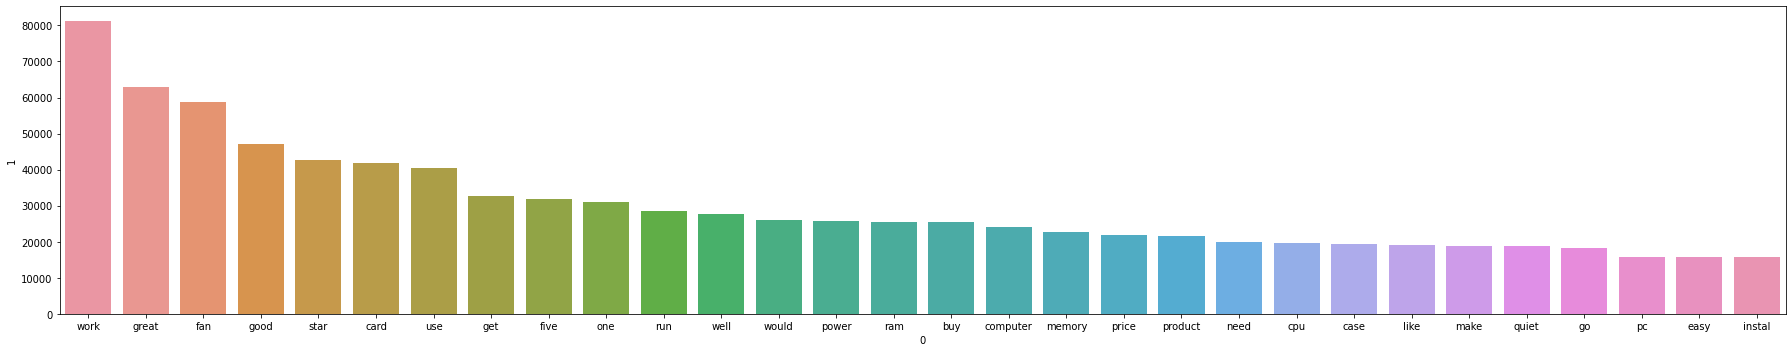

In [7]:
data = pd.DataFrame(Counter(tokens).most_common(30))
fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(x=data[0], y=data[1], ax=ax)
fig.tight_layout()

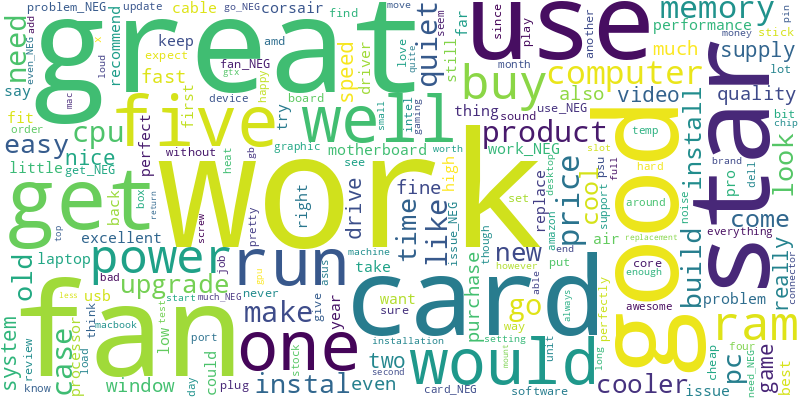

In [8]:
# generate the word cloud
wc = WordCloud(
    collocations=False,
    prefer_horizontal=0.6,
    width=800,
    height=400,
    background_color="white",
)
wc.fit_words(c)
wc.to_image()

In [9]:
# ground truth polarity
reviews_df["overall"] = reviews_df["overall"].parallel_apply(
    lambda x: "positive" if x > 3 else ("neutral" if x == 3 else "negative")
)

In [10]:
positive_df = reviews_df[reviews_df["overall"] == "positive"]
positive_tokens = [
    word for doc in positive_df["tokens"] for sent in doc for word in sent
]
pos_c = Counter(positive_tokens)

print("positive tokens:", len(set(positive_tokens)))

negative_df = reviews_df[reviews_df["overall"] == "negative"]
negative_tokens = [
    word for doc in negative_df["tokens"] for sent in doc for word in sent
]
neg_c = Counter(negative_tokens)

print("negative tokens:", len(set(negative_tokens)))

positive tokens: 44710
negative tokens: 19921


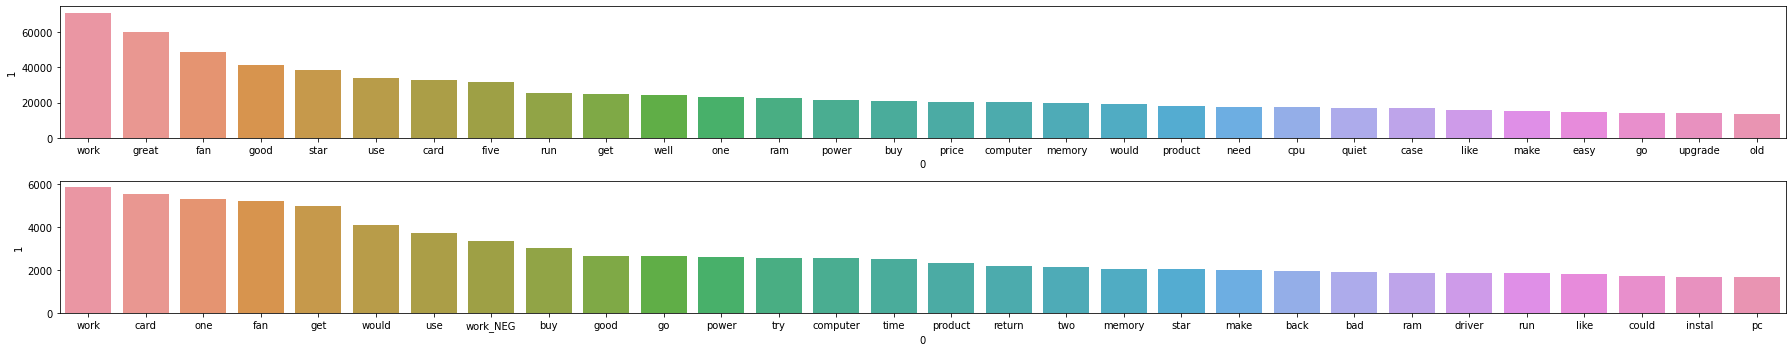

In [11]:
pos_data = pd.DataFrame(Counter(positive_tokens).most_common(30))
neg_data = pd.DataFrame(Counter(negative_tokens).most_common(30))

fig, ax = plt.subplots(2, 1, figsize=(25, 5))
sns.barplot(x=pos_data[0], y=pos_data[1], ax=ax[0])
sns.barplot(x=neg_data[0], y=neg_data[1], ax=ax[1])
fig.tight_layout()

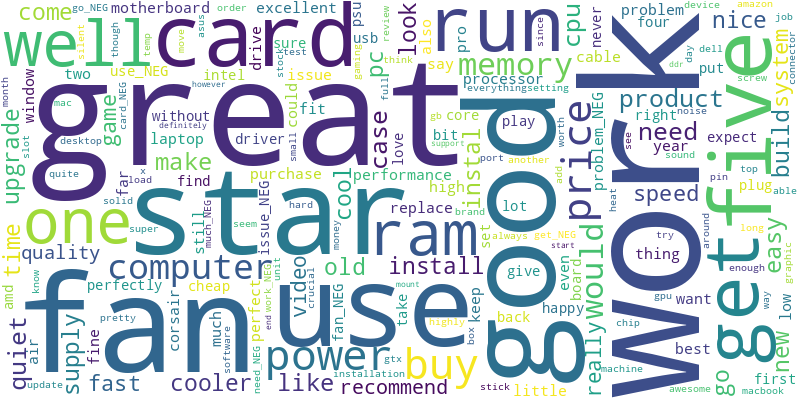

In [12]:
# generate the word cloud
wc = WordCloud(
    collocations=False,
    prefer_horizontal=0.6,
    width=800,
    height=400,
    background_color="white",
)
wc.fit_words(pos_c)
wc.to_image()

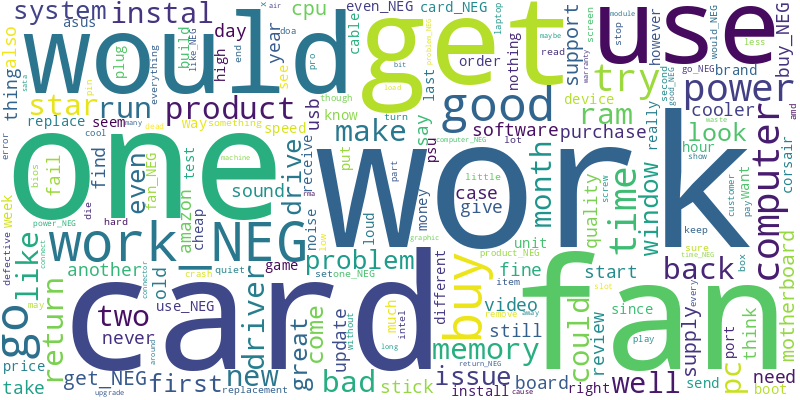

In [13]:
# generate the word cloud
wc = WordCloud(
    collocations=False,
    prefer_horizontal=0.6,
    width=800,
    height=400,
    background_color="white",
)
wc.fit_words(neg_c)
wc.to_image()

In [14]:
vocabulary = dict((e, i) for i, e in enumerate(set(tokens)))
print("Vocabulary size:", len(vocabulary))

# save vocabulary for asum input
np.save(asum_input_dir / "vocabulary", vocabulary)

Vocabulary size: 50725


# Look for bad results

In [15]:
# check long words
set([t for t in tokens if len(t) > 15])

{'abreviations_NEG',
 'acceleration_NEG',
 'accessvbscript_NEG',
 'accidentally_NEG',
 'accommodating_NEG',
 'accommodation_NEG',
 'accomodating_NEG',
 'accomplishment_NEG',
 'accumulation_NEG',
 'accumulative_NEG',
 'acknowledgement_NEG',
 'acknowledgment_NEG',
 'additionally_NEG',
 'administration_NEG',
 'administrator_NEG',
 'adubbproductions',
 'advantageous_NEG',
 'advertisement_NEG',
 'advertisiing_NEG',
 'aesthetically_NEG',
 'affordability_NEG',
 'aforementioned_NEG',
 'afterthought_NEG',
 'airconditioning_NEG',
 'aircraftvlanding',
 'amazonpcbuildercom',
 'amazonpcbuildercom_NEG',
 'amdcleanuputility',
 'amplification_NEG',
 'amuletdevices_NEG',
 'announcement_NEG',
 'antialiasing_NEG',
 'antivibration_NEG',
 'appreciation_NEG',
 'appreciative_NEG',
 'appropriately_NEG',
 'approximately_NEG',
 'approximation_NEG',
 'archaeologically_NEG',
 'architectural_NEG',
 'architecture_NEG',
 'argumentatively_NEG',
 'arquitecture_NEG',
 'astonishingly_NEG',
 'astronomical_NEG',
 'astroph

In [16]:
strange_tokens = ["clockwatchdogtimeout"]

In [17]:
for q in strange_tokens:
    for i, row in reviews_df.iterrows():
        if q in [t for s in row["tokens"] for t in s]:
            print(row["text"])
            print(row["tokens"])
            print("\n")

Lasted about 3 months, now continually getting CLOCK_WATCHDOG_TIMEOUT errors while doing menial tasks. I blame poor binning. This is 6600k #2 for this build, never clocked past 3.9.
[['blame', 'poor', 'binning'], ['build'], ['last', 'month', 'continually', 'get', 'clockwatchdogtimeout', 'error', 'menial', 'task'], ['blame', 'poor', 'binning'], ['build', 'never', 'clock_NEG', 'past_NEG']]


